In [561]:
from time import time
import re

from playwright.async_api import async_playwright
from langchain_core.tools import tool

class Scrapper:
  def __init__(self):
    self.page = None
    self.broser = None
    self.playwright = None
  
  async def initialize(self, url: str, headless: bool = True) -> None:
    self.playwright = await async_playwright().start()
    self.browser = await self.playwright.chromium.launch(headless=headless)
    self.page = await self.browser.new_page()
    await self.page.goto(url)
    await self.page.wait_for_load_state()
  
  async def close(self) -> None:
    if self.browser:
      await self.browser.close()
    if self.playwright:
      await self.playwright.stop()

  async def extract_elements(self, el_selector: str, trunc: bool = True, limit: int = 50, compact: bool = False):
    """
      Extracts elements from the page based on the provided selector.
      Args:
        el_selector (str): The selector to find elements.
        trunc (bool): Whether to truncate the text content. Default is True.
        limit (int): The maximum number of elements to extract. Default is 50.
        compact (bool): Whether to compact identical elements with a count. Default is False.
      Returns:
        str: A formatted string with the extracted elements.
    """
    try:
      elements = await self.page.query_selector_all(el_selector)
      formatted_elements = []
      last_element = {'el': None, 'count': 0}
      
      for el in elements:
        element = await self.__serialize_element(el, trunc)
        
        if compact and self.__isDuplicated(last_element, element):
          updated__last_element = last_element['el'].copy()
          updated__last_element['Count'] = last_element['count']
          formatted_elements[-1] = self.__stringfy_element(updated__last_element)
        else:
          formatted_elements.append(self.__stringfy_element(element))

        if len(formatted_elements) >= limit:
          break
      
      if len(formatted_elements) == 0:
        formatted_elements.append("No elements found")

      return "Extracted elements:\n-" + "\n- ".join(formatted_elements)
    except Exception as e:
      return f"Error running 'extract_elements'. Error: {str(e)}"

  async def __serialize_element(self, el, trunc):
    tag_name = (await el.evaluate('el => el.tagName')).lower()
    
    element = { "Element": tag_name }

    class_name = (await el.evaluate('el => el.className')).strip()
    if class_name:
      element['Classes'] = class_name
    
    text = re.sub(r'\s+', ' ', (await el.text_content()).strip())
    if text:
      formatted_text = text if not trunc else text[:50] + "..." if len(text) > 50 else text
      element['Text'] = formatted_text

    if tag_name == "a":
      element['Href'] = await el.get_attribute("href")

    if tag_name == "input":
      element['Placeholder'] = await el.get_attribute("placeholder") or "no placeholder"
      element['Name'] = await el.get_attribute("name") or "no name"
    
    return element
  
  def __stringfy_element(self, el):
    if isinstance(el, dict):
      return " ".join([f"{key}: {value}" for key, value in el.items()])
    return str(el)
  
  def __isDuplicated(self, last_element, element):
    if last_element['el'] is None:
      last_element['el'] = element
      last_element['count'] = 1
      return False

    if last_element['el']['Element'] == element['Element'] \
      and last_element['el']['Classes'] == element['Classes']:
      last_element['count'] += 1
      return True
        
    last_element['el'] = element
    last_element['count'] = 1
    return False

  async def interact_with_element(self, el_selector: str, interaction: str, text: str):
    """
      Interacts with an element on the page based on the provided selector.
      Args:
        el_selector (str): The selector to find the element.
        interaction (str): The type of interaction to perform (click, fill).
        text (str): The text to fill in the element if applicable.
      Returns:
        str: A message indicating the result of the interaction.
    """
    try:
      element = await self.page.query_selector(el_selector)
      
      if element is None:
        return f"Element with selector '{el_selector}' not found."

      if interaction == "click":
        await element.click()
        return f"Element '{el_selector}' clicked."

      if interaction == "fill":
        await element.type(text)
        return f"Text '{text}' typed in element '{el_selector}'."
      
      return "Unsupported interaction."
    except Exception as e:
      return f"Error running 'extract_elements'. Error: {str(e)}"
  
  async def print_page(self):
    """
      Takes a screenshot of the current page and saves it to a file.
      Returns:
        str: The file path of the saved screenshot.
    """
    try:
      timestamp = str(round(time()))
      fileName= f"./temp/print_{timestamp}.png"
      await self.page.screenshot(path=fileName, full_page=True)
      return fileName
    except Exception as e:
      return f"Error running 'print_page'. Error: {str(e)}"
  
  async def page_summary(self):
    """
      Summarizes the current page by extracting the URL, title, description, text elements
      and interaction elements.
      Returns:
        str: A formatted string with the page summary.
    """
    try:
      url = self.page.url
      title = await self.page.title()
      description = await self.page.evaluate("() => document.querySelector('meta[name=\"description\"]')?.getAttribute('content') || 'No description available'")
      
      text_elements_tags = "h1, h2, h3, h4, p, li, td, th, label"
      interaction_elements_tags = "a, button, input"

      text_elements = await self.extract_elements(text_elements_tags, True, 3000, True)
      interaction_elements = await self.extract_elements(interaction_elements_tags, True, 3000, True)

      return f"URL: {url}\n" \
        + f"Title: {title}\n" \
        + f"Description: {description}\n" \
        + f"Text elements: \n{text_elements}\n" \
        + f"Interaction elements: \n{interaction_elements}"
    except Exception as e:
      return f"Error running 'page_summary'. Error: {str(e)}"
    
  async def navigate(self, url: str):
    """
      Navigates to a new URL.
      Args:
        url (str): The URL to navigate to.
      Returns:
        str: A message indicating the result of the navigation.
    """
    try:
      await self.page.goto(url)
      await self.page.wait_for_load_state()
      return f"Navigated to {url}"
    except Exception as e:
      return f"Error running 'navigate'. Error: {str(e)}"

In [562]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.prebuilt import ToolNode, tools_condition


In [563]:
class State(TypedDict):
  messages: Annotated[list, add_messages]

In [564]:
url         = "https://books.toscrape.com"
site_info   = "All products | Books to Scrape - Sandbox\nBooks · Travel · Mystery · Historical Fiction · Sequential Art · Classics · Philosophy · Romance · Womens Fiction · Fiction · Childrens · Religion ..."
query       = "Quero comprar: todos os livros de ficção científica"
all_results = True
debug       = True

In [565]:
scrapper = Scrapper()
await scrapper.initialize(url, headless=True)

In [566]:
import base64

from langchain_core.language_models import BaseChatModel
from langchain_core.messages import HumanMessage


def encode_image(image_path: str) -> str:
  """Encode image to base64 string"""
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode("utf-8")  
  
def describe_web_page_print(vision_llm: BaseChatModel, fileName: str) -> str:
  try:
    encoded_print = encode_image(fileName)

    message = HumanMessage(
      content=[
        {
          "type": "text", 
          "text": "Provide a comprehensive and detailed description of this webpage screenshot.\n\nProvide a structured response with sections and bullet points about the page title and purpose, main navigation elments, primary content, interactive elements, current state, possible actions, page structure, unique identifiers.\n\nScreenshot analysis:\n"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{encoded_print}"
          }
        }
      ]
    )
    description = vision_llm.invoke([message]).content

    return description
  except Exception as e:
    return f"Error tryning to describe the page print. Error: {str(e)}"

In [567]:
import os

@tool
async def extract_elements(el_selector: str, trunc: bool = True, limit: int = 50, compact: bool = False) -> str:
  """
  Extracts elements from the page based on the provided selector.
  Args:
    el_selector (str): The selector to find elements.
    trunc (bool): Whether to truncate the text content. Default is True.
    limit (int): The maximum number of elements to extract. Default is 50.
    compact (bool): Whether to compact identical elements with a count. Default is False.
  Returns:
    str: A formatted string with the extracted elements.
  """
  return await scrapper.extract_elements(el_selector, trunc, limit, compact)

@tool
async def interact_with_element(el_selector: str, interaction: str, text: str = "") -> str:
  """
  Interacts with an element on the page based on the provided selector.
  Args:
    el_selector (str): The selector to find the element.
    interaction (str): The type of interaction to perform (click, fill).
    text (str): The text to fill in the element if applicable.
  Returns:
    str: A message indicating the result of the interaction.
  """
  return await scrapper.interact_with_element(el_selector, interaction, text)

@tool
async def print_page() -> str:
  """
  Takes a screenshot of the current page and returns a dscription of the page.
  Returns:
    str: A description of the page.
  """
  filename = await scrapper.print_page()
  vision_llm = ChatOpenAI(model="gpt-4o")
  page_description = describe_web_page_print(vision_llm, filename)
  os.remove(filename)
  return page_description

@tool
async def page_summary() -> str:
  """
  Summarizes the current page by extracting the URL, title, description, text elements
  and interaction elements.
  Returns:
    str: A formatted string with the page summary.
  """
  return await scrapper.page_summary()

@tool
async def navigate(url: str) -> str:
  """
  Navigates to a new URL.
  Args:
    url (str): The URL to navigate to.
  Returns:
    str: A message indicating the result of the navigation.
  """
  return await scrapper.navigate(url)

# Combine all tools into a list
scrapping_tools = [extract_elements, interact_with_element, print_page, page_summary, navigate]

In [568]:
graph_builder = StateGraph(State)

In [569]:
llm_capitan = ChatOpenAI(model="gpt-4o-mini")

capitan_prompt = ChatPromptTemplate.from_messages([
  ("system", """
# Função
Você é um assistente de que ajuda pessoas com deficiência visual planejar como navegar e interagir com páginas da web.

# Tarefa
Com base na **query do usuário** e na **página atual**, sua missão é planejar a próximo ação que deve ser executado na página afim de atender a query do usuário.

## Entrada
Você receberá:
- **Site**: URL do site que está visitando
- **Site_info**: Breve descrição do site
- **Query**: O que o usuário deseja encontrar ou fazer
- **All**: Se "true", extraia TODAS as informações relevantes; se "false" ou omitido, extraia apenas o básico

## Estratégia Adaptativa

1. **Analise o contexto do site**:
   - Identifique o tipo de site (e-commerce, blog, fórum, informativo, etc.)
   - Adapte sua abordagem ao propósito do site e à query
   - Seja flexível na estratégia de extração

2. **Sequência de navegação inteligente**:
   - Inicie com `print()` para entender a estrutura da página
   - **Verifique se os elementos existem antes de interagir**:
     - Sempre extraia elementos antes de tentar interagir com eles
     - Use extração para verificar a presença de elementos interativos
   - Identifique o caminho mais eficiente para os dados:
     - Verifique se há barra de pesquisa (prioridade se relevante à query)
     - Examine menus de navegação, filtros ou categorias
     - Considere links diretos que possam levar ao conteúdo desejado
   - Use `print()` APENAS após uma ação que altere a página
   - Extraia os dados após encontrar a informação relevante
   - Se `All=true`, obtenha dados completos:
     - Use limite elevado nas extrações (ex: '50', '100')
     - Explore paginação quando presente

3. **Pensamento em voz alta**:
   - Um pensamento por linha
   - Máximo 5 palavras por linha
   - Seja direto e específico

## Ações:
  - 'EXTRACT': Extraia elementos da página 
  - 'INTERACT': Interaja com um elemento (clicar ou preencher um input)
  - 'NAVIGATE': Navege para uma nova URL
  - 'SUMMARIZE': Uma breve descrição da página
  - 'PRINT': Tire um print da página e receba uma descrição dela
  - 'END_NAVIGATION': Finalize a execução

## Exemplos:
- Exemplo 1:
    Estou em uma nova página
    preciso de mais informações
    -####-
    SUMMARIZE
    preciso de mais informações sobre o site que estou
- Exemplo 2:
    Estou em um e-commerce
    quero comprar um livro
    vou procurar na barra de pesquisa
    devo buscar por inputs
    -####-
    EXTRACT
    quero inputs de pesquisa

# Regras Críticas
- APENAS UMA AÇÃO POR VEZ
- **VERIFIQUE SE ELEMENTOS EXISTEM** antes de interagir com eles
- **ADAPTE-SE ao tipo de site** - não assuma a estrutura do site, extraia elementos e tire prints
- Execute apenas uma ação por mensagem
- **NUNCA use formatação Markdown ou marcadores de código (```)** nos comandos
- Se estiver perdido, use a ação `SUMMARIZE`, use extraia seletores genéricos ou então use a ação 'PRINT()'
- Para seletores com atributos, use aspas simples externas
  - `extract_elements('[class*="content"]', 'True', '20')`
- Com **All=true**, especifique limite alto na extração
- Com **All=true**, use paginação quando presente
- Após `end()`, na linha seguinte, adicione resposta fomatada em:
  - `csv` se for uma lista de produtos
  - `markdown` em qualquer outro caso
  OBS: não esqueça de incluir links de referênci em ambos os casos
- SEMPRE inclua o separador antes do comando
- **NUNCA combine seletores** (ex: 'h1, h2, h3')
"""),
  MessagesPlaceholder("messages")
])

async def capitan(state: State):
  message = await (capitan_prompt | llm_capitan).ainvoke(state["messages"])
  print(f"\nCAPITAN 👲 -> {message.content}")
  return {"messages": [message]}

graph_builder.add_node("capitan", capitan)

In [570]:
llm_deckhand = ChatOpenAI(model="gpt-4o-mini")

deckhand_prompt = ChatPromptTemplate.from_messages([
  ("system", """
# Função
Você é um assistente de que ajuda pessoas com deficiência visual navegar e interagir com páginas da web.

# Tarefa
Com base no solicitado você deve executar a ferramenta apropriada.
"""),
  MessagesPlaceholder("messages")
])

async def deckhand(state: State):
  message = await (deckhand_prompt | llm_deckhand.bind_tools(scrapping_tools)).ainvoke(state["messages"])
  print(f"\nDECKHAND 🚣‍♂️ -> '{message.content}' ferramentas: {message.tool_calls}")
  # assert len(message.tool_calls) <= 1
  return {"messages": [message]}

graph_builder.add_node("deckhand", deckhand)

In [571]:
llm_lookout = ChatOpenAI(model="gpt-4o-mini")

lookout_prompt = ChatPromptTemplate.from_messages([
  ("system", """
# Função
Você é um assistente de que ajuda pessoas com deficiência visual a entender o que é extraído de páginas da web.

# Tarefa
Com base no que histórico de mensagens você deve estruturar uma resposta detalhada contendo as informações relevantes para o usuário.
"""),
  MessagesPlaceholder("messages")
])

async def lookout(state: State):
  message = await (lookout_prompt | llm_lookout).ainvoke(state["messages"])
  print(f"\nLOOKOUT 🔭 -> {message.content}")
  return {"messages": [message]}

graph_builder.add_node("lookout", lookout)

In [572]:
from langchain_core.messages import ToolMessage

tools_by_name = {tool.name: tool for tool in scrapping_tools}
async def tools_node(state: dict):
  result = []
  for tool_call in state["messages"][-1].tool_calls:
    tool = tools_by_name[tool_call["name"]]
    observation = await tool.ainvoke(tool_call["args"])
    result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
  print(f"\TOOLS 🛠️ -> {result}")  
  return {"messages": result}

graph_builder.add_node("tools", tools_node)

In [ ]:
def should_end(state: State) -> Literal["deckhand", "lookout"]:
  """Decides whether to end the navigation or not."""
  last_message = state["messages"][-1]
  result = "deckhand" if "END_NAVIGATION" not in last_message.content else "lookout"
  print(f"\nSHOULD_END ❓ -> {result}")
  return result

In [574]:
graph_builder.set_entry_point("capitan")
graph_builder.add_conditional_edges("capitan", should_end)
graph_builder.add_edge("deckhand", "tools")
graph_builder.add_edge("tools", "capitan")
graph_builder.add_edge("lookout", END)

In [575]:
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

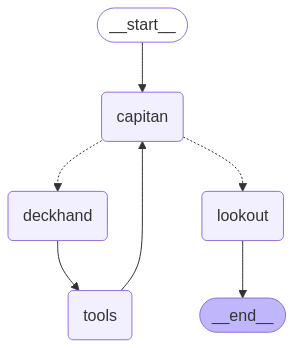

In [576]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  # This requires some extra dependencies and is optional
  pass

In [577]:
initial_state = {
  "messages": [
    HumanMessage(content=f"Site: {url}\nSite_info: {site_info}\nQuery: {query}\nAll: {all_results}")
  ]
}
config = {"configurable": {"thread_id": "1"}, "recursion_limit": 100} 

In [578]:
result = await graph.ainvoke(initial_state, config)
await scrapper.close()
result["scrapper"] = "scrapper"


CAPITAN 👲 -> PRINT  
Vou verificar a estrutura da página e localização dos livros.

SHOULD_END 🔣 -> deckhand

DECKHAND 🚣‍♂️ -> '' ferramentas: [{'name': 'print_page', 'args': {}, 'id': 'call_rnxdzKE0nqfADbvKVSB97Sof', 'type': 'tool_call'}]
\TOOLS 🛠️ -> [ToolMessage(content='**Webpage Description**\n\n### Page Title and Purpose\n- **Title**: Books to Scrape\n- **Purpose**: A demo website designed for practicing web scraping. It provides a variety of book listings with prices and availability.\n\n### Main Navigation Elements\n- **Home Link**: Returns the user to the homepage.\n- **Breadcrumbs Navigation**: \n  - Home > All products\n\n### Primary Content\n- **Heading**: "All products"\n- **Product Listings**:\n  - Displays 20 book items out of 1000 total products.\n  - Each item includes:\n    - Book cover image\n    - Title (e.g., "A Light in the Attic")\n    - Star rating\n    - Price (e.g., £51.77)\n    - Availability status (e.g., "In stock")\n    - "Add to basket" button\n\n### Int